In [93]:
import pandas as pd
import scanpy as sc
from sklearn.metrics import mean_squared_error
from scipy.sparse import issparse
from matplotlib import pyplot as plt

%matplotlib inline

import numpy as np
from tqdm import tqdm

For ease of comparison, each run of a denoiser at some parameters will be stored in an AnnData object, along with the MCV. A sweep may generate many such objects. Note that the MCV calculation is different than just running the denoiser. These can be done simultaneously, to save memory, but also generated one-by-one, as for scVI.

For a denoised anndata object,

* `X` contains denoised values (in count space)
* `denoiser_name`  names the denoiser
* `denoising_function` is the function itself
* `denoiser_kwargs` are keyword arguments for the denoiser
* `denoiser_model` contains a fitted model if one exists

We stash the MCV:
* `mcv` contains the mcv loss (computed from one or many iterations)

The things needed for comparing methods are:

* `de` contains DE genes for each comparison
* `obsm.cluster` contains output of clustering
* `varm.ggcorr` contains gene-gene correlation matrix

# Function Defs

In [5]:
from sweep import *
from downstream import *
from data import *

In [7]:
data_dir = '/mnt/ibm_lg/james/mcv_workspace/data/'

In [4]:
adata = load_data("symsim2k", data_dir)

# scVI

In [12]:
from typing import Tuple

import scvi
from scvi.dataset import AnnDatasetFromAnnData
from scvi.inference import UnsupervisedTrainer
from scvi.models.vae import VAE
import torch
from scvi.models.log_likelihood import log_nb_positive

In [13]:
def compute_scvi_latent(
    adata: sc.AnnData,
    n_latent: int = 5,
    n_epochs: int = 100,
    lr: float = 1e-3,
    use_batches: bool = False,
    use_cuda: bool = False,
    val: bool = False
) -> Tuple[scvi.inference.Posterior, np.ndarray]:
    # Convert easily to scvi dataset
    scviDataset = AnnDatasetFromAnnData(adata)

    # Train a model
    vae = VAE(
        scviDataset.nb_genes,
        n_batch=scviDataset.n_batches * use_batches,
        n_latent=n_latent,
        reconstruction_loss = 'nb',
        n_hidden=128
        
    )
    if val:
        train_size = 0.9
    else:
        train_size = 1.0
    trainer = UnsupervisedTrainer(vae, scviDataset,
                                  train_size=train_size, use_cuda=use_cuda,
                                  frequency=5,
#                                   n_epochs_kl_warmup=1e6
                                  )
    trainer.train(n_epochs=n_epochs, lr=lr)

    posterior = trainer.create_posterior(
        trainer.model, scviDataset, indices=np.arange(len(scviDataset))
    ).sequential()

    latent, _, _ = posterior.get_latent()

    return posterior, latent, trainer

In [14]:
@torch.no_grad()
def get_sample_rate(posterior):
    px_scales = []
    for tensors in posterior:
        sample_batch, _, _, batch_index, labels = tensors
        px_scales += [
            np.array(
                (
                    posterior.model.get_sample_rate(
                        sample_batch, batch_index=batch_index, y=labels, n_samples=1
                    )
                ).cpu()
            )
        ]
    return np.concatenate(px_scales)

In [15]:
def scvi_likelihood(posterior, x_valid, validation_to_train_ratio = None, n_samples = 1):
    """Compute negative binomial likelihood of x_valid with respect to the posterior."""
    nll = 0
    for i in range(n_samples):
        px_r = torch.exp(posterior.model.px_r.detach().cpu())

        if validation_to_train_ratio is None:
            px_scale = posterior.get_sample_scale()
            library = x_valid.sum(1)
            px_rate = px_scale*library.reshape(-1,1)
        else:
            px_rate = get_sample_rate(posterior) * validation_to_train_ratio

        x_valid, px_rate, px_r = [torch.Tensor(t) for t in [x_valid, px_rate, px_r]]

        nll += -log_nb_positive(x_valid, px_rate, px_r).mean(dim=-1).mean().item()
    return nll/n_samples

In [16]:
def sweep_scvi(base_adata, max_latent=30, p=0.9, n_epochs=300):
    adata = base_adata.copy()
    adata1, adata2 = split_adata(adata, p)

    k_range = np.arange(10, max_latent + 5, 5)
    denoised = []
    
    for i, k in enumerate((k_range)):
        print(f"Computing n_latent = {k}")
        scvi.set_verbosity(0)
        
        posterior1, _, _ = compute_scvi_latent(adata1, n_latent=k, n_epochs=n_epochs, use_cuda=False)
        mcv = scvi_likelihood(posterior1, adata2.X, validation_to_train_ratio=(1-p)/p)

        posterior, latent, trainer = compute_scvi_latent(adata, n_latent=k, n_epochs=n_epochs)

        adata_denoised = sc.AnnData(X = get_sample_rate(posterior),
                           uns = {'denoiser': 'scvi',
                                  'denoiser_param': k,
                                  'scvi_posterior': posterior,
                                  'mcv': mcv,
                                  'trainer': trainer
                                  },
                            obs = base_adata.obs,
                            obsm = {'X_latent': latent})
        denoised.append(adata_denoised)
    return denoised

def compute_gt_scvi(adata_denoised, adata):
    X_true = adata.obsm['X_true']
    posterior = adata_denoised.uns['scvi_posterior']
    adata_denoised.uns['gt_lik'] = scvi_likelihood(posterior, X_true)
                                        
def compute_de_scvi(adata_denoised, label):
    raise NotImplementedError()

In [29]:
adata = sc.datasets.paul15()

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


In [35]:
sc.pp.filter_genes(adata, min_cells = 100)

In [45]:
posterior1, latent, trainer = compute_scvi_latent(adata, n_latent=100, n_epochs=1000, use_cuda=True, val = True)

[2020-03-05 19:12:23,592] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-03-05 19:12:23,594] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-03-05 19:12:23,955] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-05 19:12:23,973] INFO - scvi.dataset.dataset | Downsampled from 2730 to 2730 cells


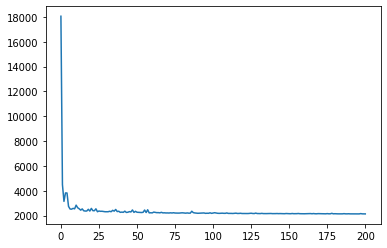

In [46]:
plt.plot(trainer.history['elbo_train_set'])
plt.show()

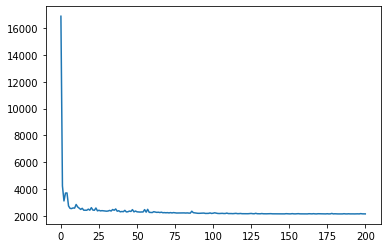

In [47]:
plt.plot(trainer.history['elbo_test_set'])
plt.show()

In [41]:
denoised = posterior1.get_sample_scale()

In [84]:
denoised = adata.copy()
denoised.X = posterior1.imputation()

In [59]:
'Gata1' in denoised.var.index

True

In [79]:
denoised_pca = adata.copy()
sc.pp.sqrt(denoised_pca)
sc.pp.pca(denoised_pca)
k = 25
denoised_pca.X = denoised_pca.obsm['X_pca'][:, :k].dot(denoised_pca.varm['PCs'].T[:k])

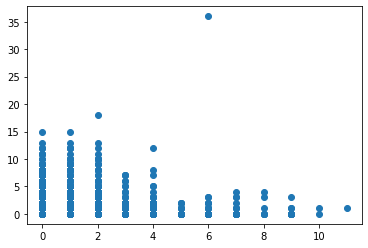

In [71]:
plt.scatter(adata[:,'Gata1'].X.T[0], adata[:,'Apoe'].X.T[0])
plt.show()

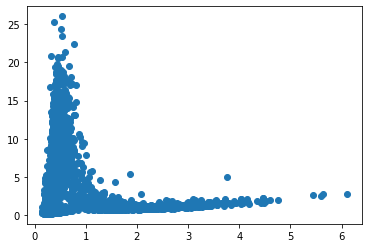

In [86]:
plt.scatter(np.sqrt(denoised[:,'Gata1'].X.T[0]), np.sqrt(denoised[:,'Apoe'].X.T[0]))
plt.show()

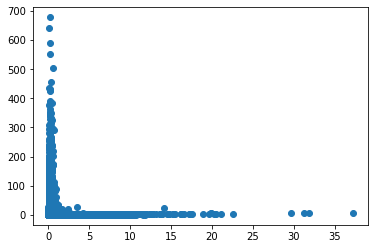

In [85]:
plt.scatter(denoised[:,'Gata1'].X.T[0], denoised[:,'Apoe'].X.T[0])
plt.show()

In [96]:
import seaborn as sns

In [89]:
import pandas as pd
denoised = adata.copy()
denoised.X = posterior1.get_sample_scale()

adata.obs['Gata1_scale'] = denoised[:,'Gata1'].X.T[0]
adata.obs['Apoe_scale'] = denoised[:,'Apoe'].X.T[0]

In [102]:
adata.obsm['X_scvi'] = latent

In [105]:
sc.pp.neighbors(adata, use_rep='X_scvi')
sc.tl.leiden(adata)

In [109]:
sc.pp.sqrt(adata)

In [106]:
sc.tl.umap(adata)

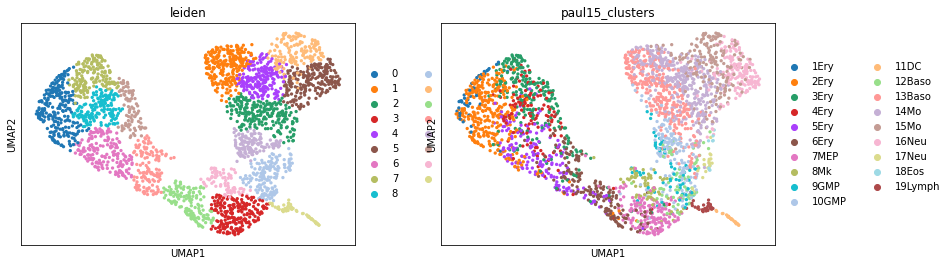

In [107]:
sc.pl.umap(adata, color = ['leiden', 'paul15_clusters'])

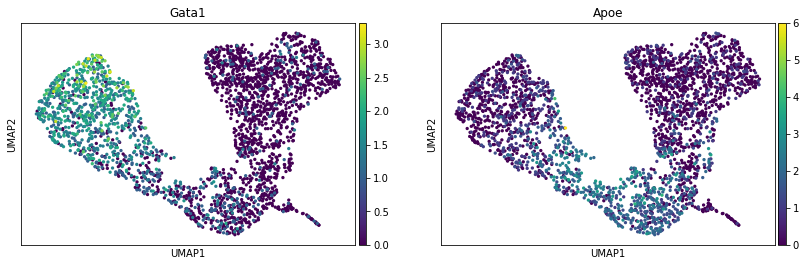

In [110]:
sc.pl.umap(adata, color = ['Gata1', 'Apoe'])

In [97]:
adata.obs['Gata1_pca'] = denoised_pca[:,'Gata1'].X.T[0]
adata.obs['Apoe_pca'] = denoised_pca[:,'Apoe'].X.T[0]

NameError: name 'denoised_pca' is not defined

In [98]:
sns.scatterplot(x='Gata1_scale', y='Apoe_scale', hue='paul15_clusters', data = adata.obs)

ValueError: Could not interpret input 'Gata1_scale'

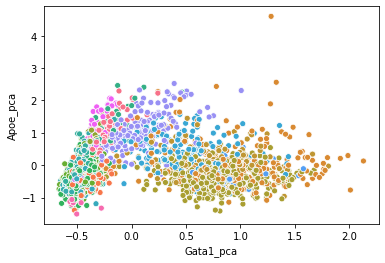

In [112]:
sns.scatterplot(x='Gata1_pca', y='Apoe_pca', hue='paul15_clusters', data = adata.obs, legend=False)

In [ ]:
sns.scatterplot(x='Gata1_scale', y='Apoe_scale', hue='paul15_clusters', data = adata.obs, legend=False)

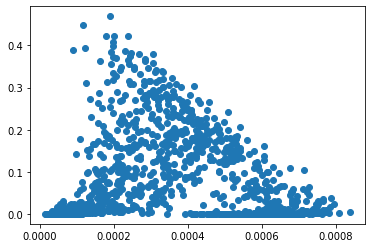

In [88]:
denoised = adata.copy()
denoised.X = posterior1.get_sample_scale()
plt.scatter(denoised[:,'Gata1'].X.T[0], denoised[:,'Apoe'].X.T[0])

In [9]:
adata = load_data("tms_deep", data_dir)

In [8]:
liver = adata[adata.obs['cell_ontology_class'] == 'Kuppfer cell'].copy()

NameError: name 'adata' is not defined

In [46]:
from molecular_cross_validation.util import poisson_fit

In [76]:
adata = load_data("tms_deep", data_dir)

In [83]:
liver = adata[adata.obs['cell_ontology_class'] == 'Kupffer cell'].copy()

In [84]:
liver.X = densify(liver.X)

In [85]:
p_val = poisson_fit(liver.X)

In [86]:
liver = sc.AnnData(X = liver.X[:,p_val < 1e-2], obs = liver.obs, 
                   var = liver.var.iloc[p_val < 1e-2],obsm={'X_true': liver.obsm['X_true'][:, p_val < 1e-4]})

(811, 362)

In [121]:
latent100.shape

(20252, 100)

In [28]:
posterior1, latent, trainer = compute_scvi_latent(adata, n_latent=100, n_epochs=500, use_cuda=True, val = True)

[2020-03-05 19:47:18,669] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-03-05 19:47:18,672] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-03-05 19:47:18,724] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-05 19:47:18,728] INFO - scvi.dataset.dataset | Downsampled from 2000 to 2000 cells


KeyboardInterrupt: 

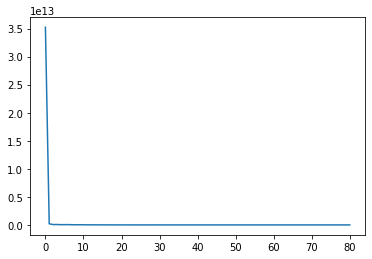

In [105]:
plt.plot(trainer10.history['elbo_test_set'])

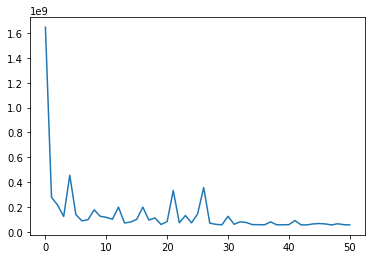

In [110]:
plt.plot(trainer30.history['elbo_train_set'][30:])

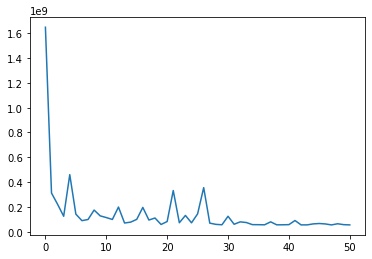

In [111]:
plt.plot(trainer30.history['elbo_test_set'][30:])

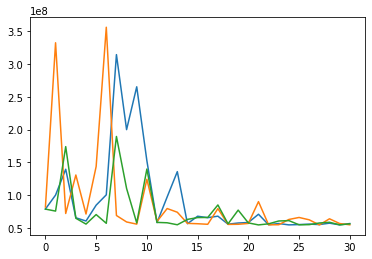

In [117]:
plt.plot(trainer10.history['elbo_train_set'][50:])
plt.plot(trainer30.history['elbo_train_set'][50:])
plt.plot(trainer100.history['elbo_train_set'][50:])

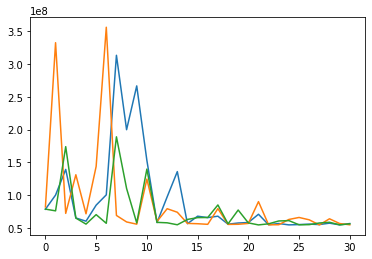

In [118]:
plt.plot(trainer10.history['elbo_test_set'][50:])
plt.plot(trainer30.history['elbo_test_set'][50:])
plt.plot(trainer100.history['elbo_test_set'][50:])

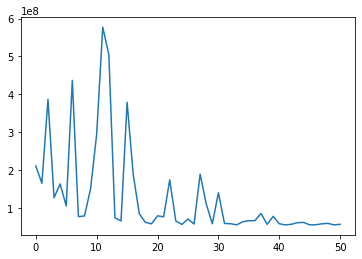

In [113]:
plt.plot(trainer100.history['elbo_test_set'][30:])

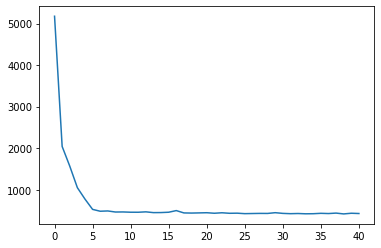

In [25]:
plt.plot(trainer.history['elbo_test_set'])

In [ ]:
posterior2, latent2, trainer2 = compute_scvi_latent(adata, n_latent=200, n_epochs=1000, use_cuda=True, val = True)

In [ ]:
posterior3, latent3, trainer3 = compute_scvi_latent(adata, n_latent=100, n_epochs=1000, use_cuda=True, val = True)

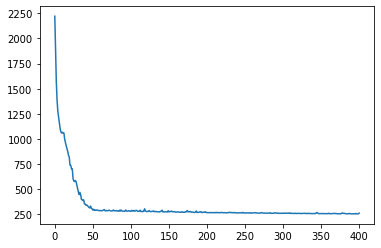

In [774]:
plt.plot(denoised_scvi[0].uns['trainer'].history['elbo_train_set'])

In [775]:
eval_denoised(denoised_scvi, symsim, 'pop',
              target_n_clusters=5,
              loss = 'scvi')

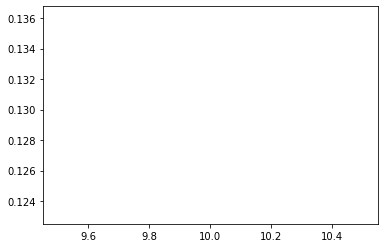

In [776]:
plot_scalar(denoised_scvi, 'mcv')

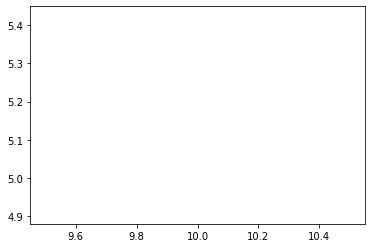

In [777]:
plot_scalar(denoised_scvi, 'gt_lik')

In [779]:
denoised_scvi[0].uns

{'denoiser': 'scvi',
 'denoiser_param': 10,
 'scvi_posterior': <scvi.inference.posterior.Posterior at 0x161f45ef0>,
 'mcv': 0.12963852286338806,
 'trainer': <scvi.inference.inference.UnsupervisedTrainer at 0x161f459b0>,
 'gt_lik': 5.164570331573486,
 'ggcorr_error': 0.5827304222804599,
 'neighbors': {'params': {'n_neighbors': 10,
   'method': 'umap',
   'metric': 'euclidean',
   'use_rep': 'X_latent'},
  'distances': <1000x1000 sparse matrix of type '<class 'numpy.float64'>'
  	with 9000 stored elements in Compressed Sparse Row format>,
  'connectivities': <1000x1000 sparse matrix of type '<class 'numpy.float64'>'
  	with 11912 stored elements in Compressed Sparse Row format>},
 'leiden': {'params': {'resolution': 0.81,
   'random_state': 0,
   'n_iterations': -1}},
 'n_clusters': 6,
 'imputed_ari': 0.4856007148735422,
 'ari': 0.5059587653805456,
 'ari_kmeans': 0.4711711283458308}

In [778]:
denoised_scvi[0].uns['scvi_posterior'].elbo(), denoised_scvi[1].uns['scvi_posterior'].elbo()

IndexError: list index out of range

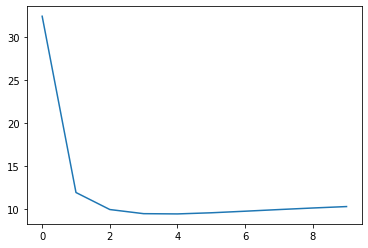

In [726]:
plot_scalar(denoised_diffusion, 'gt_lik')

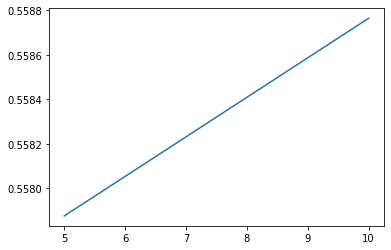

In [727]:
plot_scalar(denoised_scvi, 'ggcorr_error')

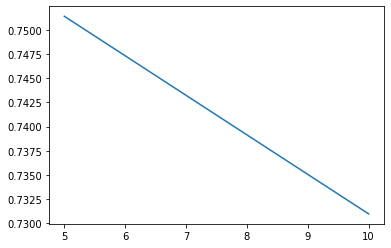

In [728]:
plot_scalar(denoised_scvi, 'ari')

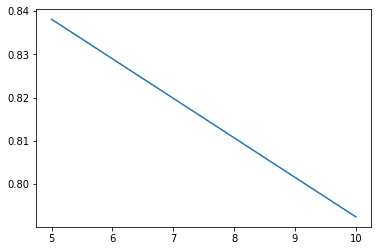

In [729]:
plot_scalar(denoised_scvi, 'ari_kmeans')

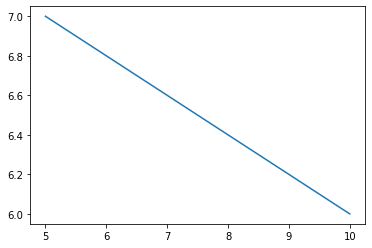

In [730]:
plot_scalar(denoised_scvi, 'n_clusters')

In [723]:
best_denoised = extract_best(denoised_scvi)

/Users/josh/src/scanpy/scanpy/plotting/_utils.py:255: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  if show: pl.show()


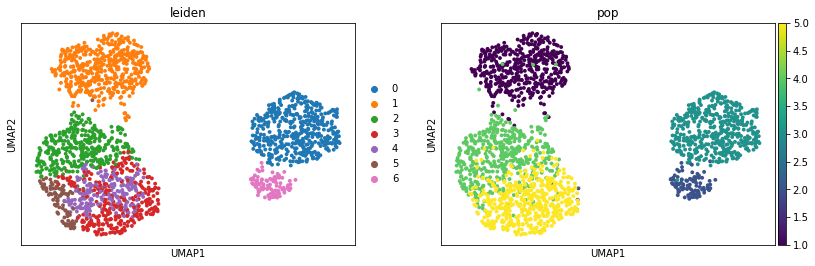

In [724]:
sc.pl.umap(best_denoised, color=['leiden', 'pop'])

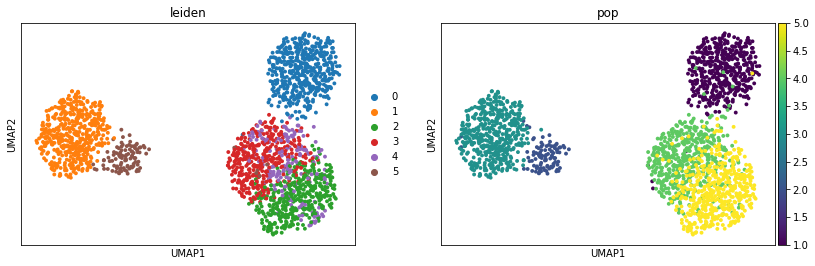

In [725]:
sc.pl.umap(denoised_scvi[-1], color=['leiden', 'pop'])

In [676]:
for adata in denoised_scvi:
    compute_cluster(adata, target_n_clusters=5, metric='cosine')
    compute_ari(adata, symsim, 'pop')

# Clustering ground-truth data

ARI from ground-truth

In [679]:
symsim_gt = symsim.copy()
symsim_gt.X = symsim.obsm['X_true']
compute_cluster(symsim_gt, target_n_clusters=5)
compute_ari(symsim_gt, symsim, 'pop')
print(symsim_gt.uns['ari'])

0.6554056185781567


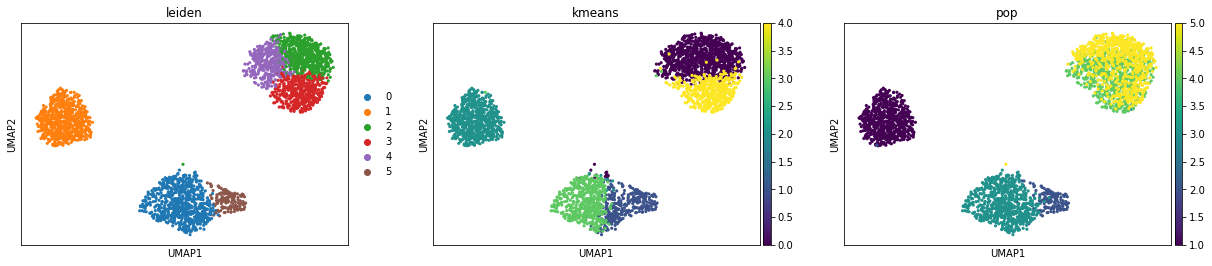

In [681]:
sc.pl.umap(symsim_gt, color=['leiden', 'kmeans', 'pop'])

# Visualizing gene correlations

In [42]:
import seaborn as sns

/Users/josh/anaconda3/envs/n2s/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


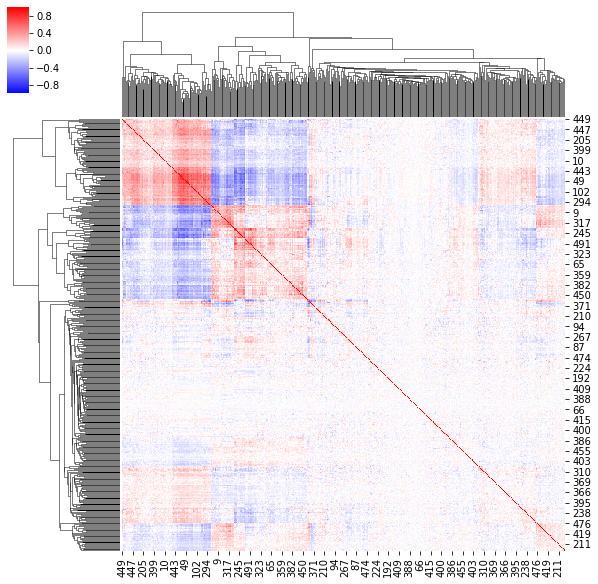

In [43]:
sns.clustermap(symsim.varm['ggcorr'], cmap = 'bwr', vmin = -1, vmax = 1)

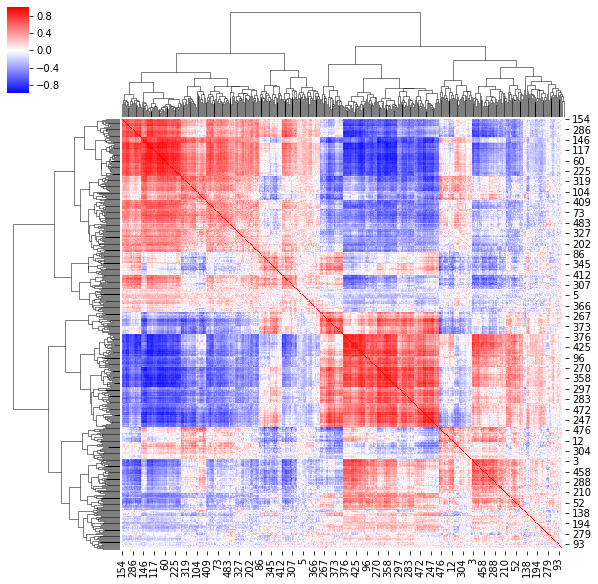

In [44]:
sns.clustermap(best_denoised.varm['ggcorr'], cmap = 'bwr', vmin = -1, vmax = 1)

# Per-Gene Diffusion

In [328]:
# Negative log likelihood
def poisson_log_lik(lam, k, per_gene = False):
    if per_gene:
        return (lam - k*np.log(lam + 1e-6)).mean(axis = 0)
    else:
        return (lam - k*np.log(lam + 1e-6)).mean()

In [322]:
%load_ext autoreload
%autoreload 2

In [353]:
symsim_gt = symsim.copy()
symsim_gt.X = symsim.obsm['X_true']
symsim_gt.raw = symsim_gt

In [364]:
adata1, adata2 = split_adata(symsim_gt, p = 0.5)
x1, x2 = adata1.X, adata2.X

In [393]:
X = symsim.X.astype(np.int)

p = 0.9

x1 = np.random.binomial(X, p)
x2 = X - x1

max_t = 20

diff_op = compute_diff_op(x1)

x1_norm = x1.astype(np.float)
x2_norm = x2.astype(np.float)

denoised = x1_norm
target = x2_norm
best_denoised = x1_norm

ss_losses = np.zeros((max_t, x1.shape[1]))

t_range = np.arange(max_t)

for t in t_range:
    ss_losses[t] = poisson_log_lik(denoised*(1-p)/p, target, per_gene=True)
    new_best_idx = (np.min(ss_losses[:(t+1)], axis=0) == ss_losses[t])
    best_denoised[:, new_best_idx] = denoised[:, new_best_idx]

    denoised = diff_op.dot(denoised)
best_t = np.argmin(ss_losses, axis=0)

(array([ 21.,  47.,  71.,  61.,  37.,  22.,  16.,  16.,  12., 197.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <a list of 10 Patch objects>)

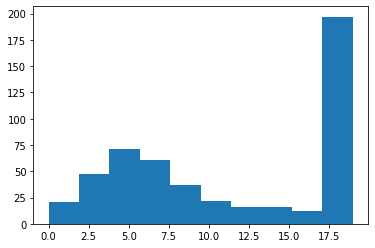

In [394]:
plt.hist(best_t)

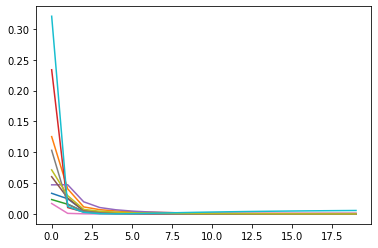

In [403]:
plt.plot((ss_losses - ss_losses.min(axis = 0))[:,::50])

In [390]:
X = symsim.X.astype(np.int)

p = 0.9

x1 = np.random.binomial(X, p)
x2 = X - x1

max_t = 20

diff_op = compute_diff_op(x1)

x1_norm = x1.astype(np.float)
x2_norm = x2.astype(np.float)

denoised = x1_norm
target = x2_norm
best_denoised = x1_norm

ss_losses = np.zeros(max_t)

t_range = np.arange(max_t)

for t in t_range:
    ss_losses[t] = poisson_log_lik(denoised*(1-p)/p, target, per_gene=False)
   
    denoised = diff_op.dot(denoised)
np.argmin(ss_losses)

7